In [1]:
!pip install -r requirements.txt

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------------- ------------------- 0.8/1.5 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.7 MB/s  0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/4 [tqdm]
   ---------------------------------------- 0/4 [tqdm]
   ---------------------------------------- 0/4 [tqdm]
   ---------------------------------------- 0/4 [tqdm]
   ---------------------------------------- 0/4 [tqdm]
   ---------------------------------------- 0/4 [tqdm]
   ---------------------------------------- 0/4 [tqdm]
   ---------- ----------------------------- 1/4 [regex]
   ---------- ----------------------------- 1/4 [regex]
   ---------- ----------------------------- 1/4 [regex]
   -------------------- ------------------- 2/4 [nltk]
   -------------------- ------------------- 2/4 [nltk]
   ----

In [10]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.model_selection import train_test_split

# deep learning imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Bidirectional

# NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
#load the IMDB dataset
df = pd.read_csv("data/train.csv")  # Update path if needed
print(df.head())
df = df.rename(columns={"text": "review", "label": "sentiment"})
df['sentiment'] = df['sentiment'].map({0: 'negative', 1: 'positive'})
print(df['sentiment'].value_counts())

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
sentiment
negative    20019
positive    19981
Name: count, dtype: int64


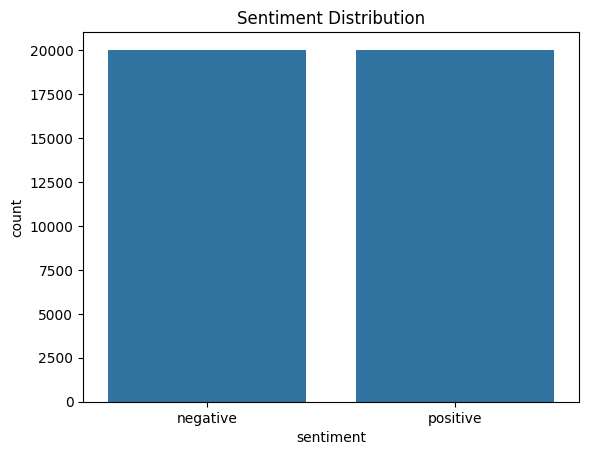

In [12]:
#plot for sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

In [13]:
#basic data cleaning
df.dropna(inplace=True)
df['review'] = df['review'].apply(lambda x: str(x).lower())

In [14]:
#pre-processiong steps
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(preprocess_text)

print("Sample cleaned review:")
print(df['clean_review'].iloc[0])

Sample cleaned review:
grew b 1965 watching loving thunderbird mate school watched played thunderbird school lunch school wanted virgil scott one wanted alan counting 5 became art form took child see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife created jonatha frakes hand director chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionette homo sapiens subsp sapiens huge error judgment


In [15]:
#tokenization and sequence preparation
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_review'])

X = tokenizer.texts_to_sequences(df['clean_review'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
y = df['sentiment'].map({'negative': 0, 'positive': 1}).values

In [16]:
#splitting the data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")

Training samples: 32000 | Test samples: 8000


In [17]:
#building and compiling LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
#training the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/5


200/200 [==============================] - 38s 158ms/step - loss: 0.4412 - accuracy: 0.7846 - val_loss: 0.3408 - val_accuracy: 0.8578
Epoch 2/5
200/200 [==============================] - 32s 160ms/step - loss: 0.2558 - accuracy: 0.9019 - val_loss: 0.3684 - val_accuracy: 0.8528
Epoch 3/5
200/200 [==============================] - 32s 158ms/step - loss: 0.1922 - accuracy: 0.9302 - val_loss: 0.4258 - val_accuracy: 0.8484
Epoch 4/5
200/200 [==============================] - 32s 158ms/step - loss: 0.1535 - accuracy: 0.9455 - val_loss: 0.4669 - val_accuracy: 0.8477
Epoch 5/5
200/200 [==============================] - 33s 165ms/step - loss: 0.1168 - accuracy: 0.9584 - val_loss: 0.5581 - val_accuracy: 0.8359


In [21]:
#saving the trained model and tokenizer to files for use in Streamlit
from tensorflow.keras.models import save_model
import pickle

model.save('lstm_model.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

D:\Anaconda\envs\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


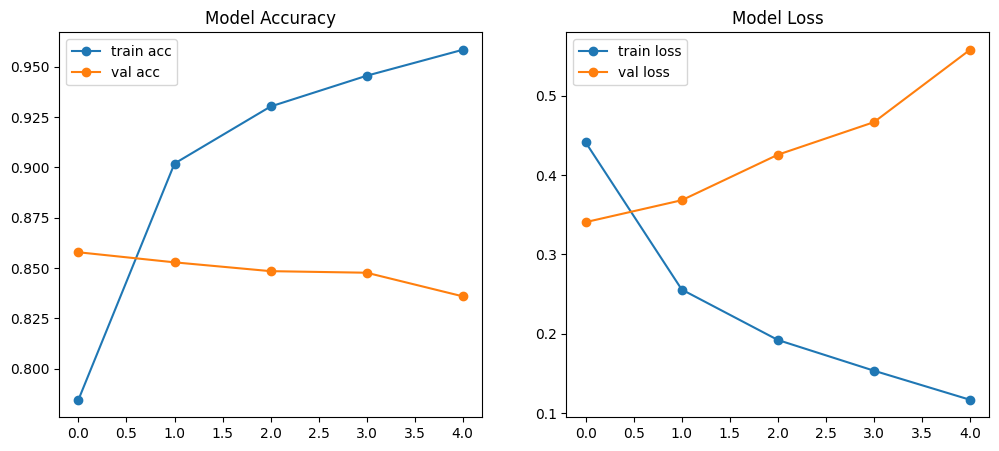

In [19]:
#plot accuracy/loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc', marker='o')
plt.plot(history.history['val_accuracy'], label='val acc', marker='o')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss', marker='o')
plt.plot(history.history['val_loss'], label='val loss', marker='o')
plt.title('Model Loss')
plt.legend()

plt.show()

In [20]:
#evaluate deep model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

250/250 [==============================] - 4s 12ms/step - loss: 0.5196 - accuracy: 0.8400
Test Accuracy: 0.8400
